# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
%cd /home/jovyan/dea_intertidal/dea-intertidal/

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [14]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install sunriset

  Using cached sunriset-1.0-py3-none-any.whl (9.6 kB)


### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from ipyleaflet import basemaps, basemap_to_tiles

import datacube
from odc.geo.geom import Geometry
from odc.ui import select_on_a_map

from intertidal.utils import (
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Setup


### Set analysis parameters

In [27]:
# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

In [28]:
# # Set study area (e.g. tile ID in form 'x143y87')
# study_area = "x100y117"
# geom = None  # Use GridSpec to load study area, not a custom geom

##### Option 2: load study area from vector file

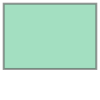

In [29]:
# Set study area to load from file
study_area = "pointstuart"

# Read file, select study area and convert to geom
studyarea_gdf = gpd.read_file(
    "data/raw/intertidal_development_polygons.geojson"
).set_index("id")
geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
geom

##### Option 3: load study area using interactive map

In [6]:
# # Set study area name for outputs
# study_area = "testing"

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
# geom

## Intertidal workflow

### Load data

In [7]:
%%time

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
)

print(satellite_ds)

# Load data
satellite_ds.load()

/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46029,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:37789,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/33173/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:46595,


<xarray.Dataset>
Dimensions:      (time: 329, y: 219, x: 317)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T01:30:39.235000 ... 2021-12...
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.404e+04 -1.404e+04 ... -1.09e+04 -1.088e+04
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 dask.array<chunksize=(1, 219, 317), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


CPU times: user 6.29 s, sys: 938 ms, total: 7.23 s
Wall time: 1min 19s


<xarray.Dataset>
Dimensions:      (time: 329, y: 219, x: 317)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T01:30:39.235000 ... 2021-12...
  * y            (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06 -1.288e+06
  * x            (x) float64 -1.404e+04 -1.404e+04 ... -1.09e+04 -1.088e+04
    spatial_ref  int32 3577
Data variables:
    ndwi         (time, y, x) float32 nan nan nan ... -0.08886 -0.08931 -0.09148
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [8]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [9]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

2023-11-20 05:30:39 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


Reprojecting tides into original array


2023-11-20 05:30:49 INFO Masking nodata and adding tide heights to satellite data array
2023-11-20 05:30:49 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2023-11-20 05:30:49 INFO Applying valid data mask to constrain study area
2023-11-20 05:30:50 INFO Running per-pixel rolling median


Reducing analysed pixels from 69423 to 35793 (51.56%)


100%|██████████| 114/114 [00:29<00:00,  3.84it/s]
2023-11-20 05:31:23 INFO Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 10


2023-11-20 05:31:23 INFO Modelling intertidal uncertainty
2023-11-20 05:31:24 INFO Unflattening data back to its original spatial dimensions
2023-11-20 05:31:24 INFO Successfully completed intertidal elevation modelling


### Intertidal extents


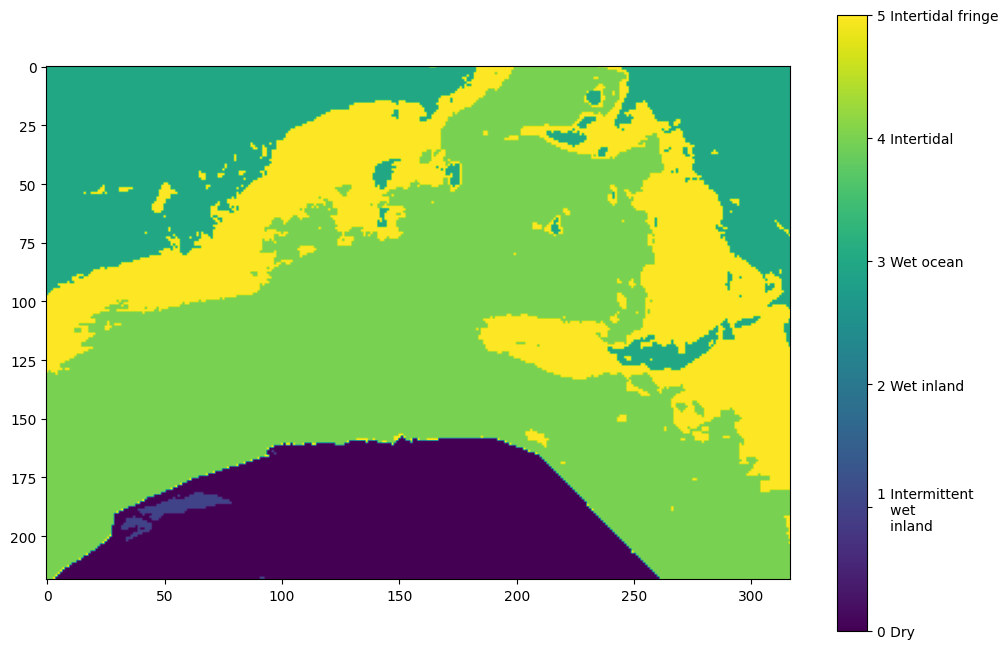

In [10]:
ds['extents'] = extents(freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr)

## Plot
labels=['0 Dry',
       '1 Intermittent\n   wet\n   inland',
       '2 Wet inland',
       '3 Wet ocean',
       '4 Intertidal',
       '5 Intertidal fringe']

fig,ax=plt.subplots(figsize=(12,8))
cax=ax.imshow(ds['extents'])
cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)
plt.show()

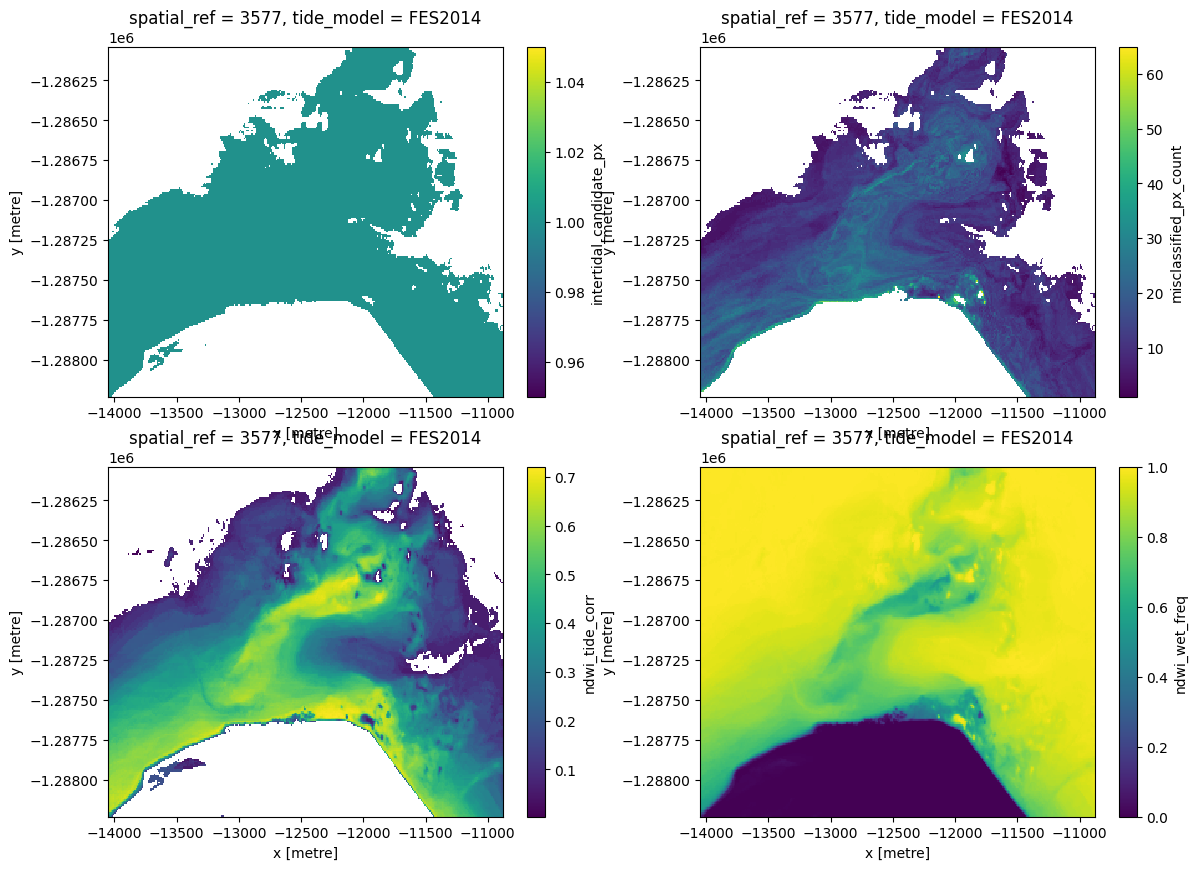

In [21]:
fig,axes = plt.subplots(2,2, figsize=(14,10))

ds_aux.intertidal_candidate_px.plot(ax=axes[0][0])
ds_aux.misclassified_px_count.plot(ax=axes[0][1])
ds_aux.ndwi_tide_corr.plot(ax=axes[1][0])
ds_aux.ndwi_wet_freq.plot(ax=axes[1][1])


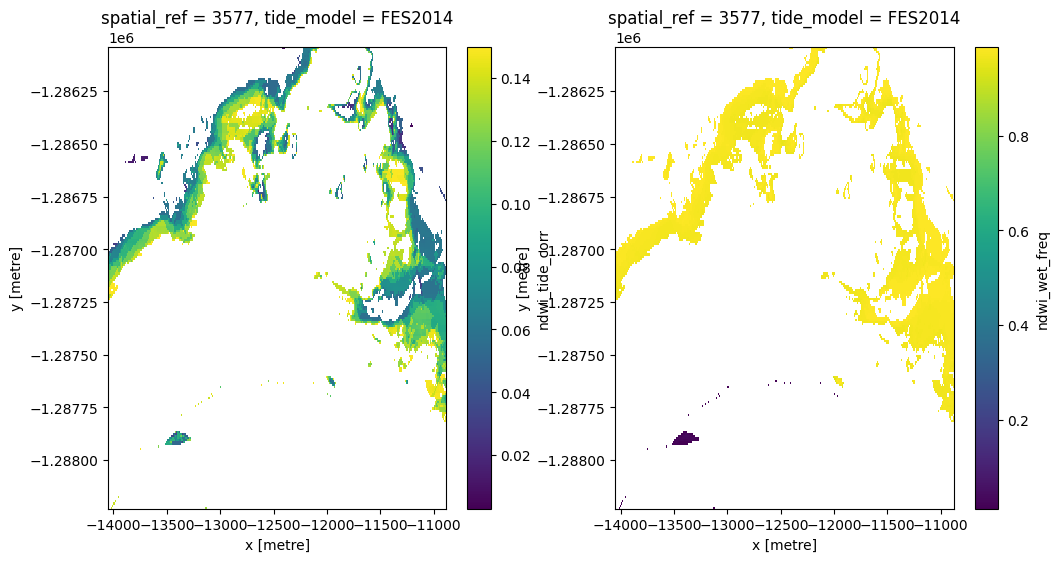

In [56]:
low_conf_int = ds_aux.ndwi_tide_corr.where(ds_aux.intertidal_candidate_px.isnull(),drop=True)
low_conf_int_freq =ds_aux.ndwi_wet_freq.where(low_conf_int.notnull())

fig,axes=plt.subplots(1,2,figsize=(12,6))
low_conf_int.plot(ax=axes[0])
low_conf_int_freq.plot(ax=axes[1])

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

<<<<<<< local <removed>
100%|██████████| 101/101 [00:00<00:00, 566.68it/s]
>>>>>>> remote <modified: >


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [13]:
(
    ds["oa_lat"],
    ds["oa_hat"],
    ds["oa_lot"],
    ds["oa_hot"],
    ds["oa_spread"],
    ds["oa_offset_lowtide"],
    ds["oa_offset_hightide"],
) = bias_offset(
    tide_m=tide_m, tide_cq=tide_cq, extents=ds.extents, lot_hot=True, lat_hat=True
)

### Tideline confidence

In [ ]:
(hightideline, lowtideline, tidelines_gdf) = tidal_offset_tidelines(
    extents=ds.extents,
    offset_hightide=ds.oa_offset_hightide,
    offset_lowtide=ds.oa_offset_lowtide,
    distance=250,
)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

<xarray.Dataset>
Dimensions:                (y: 219, x: 317)
Coordinates:
  * y                      (y) float64 -1.286e+06 -1.286e+06 ... -1.288e+06
  * x                      (x) float64 -1.404e+04 -1.404e+04 ... -1.088e+04
    spatial_ref            int32 3577
    tide_model             <U7 'FES2014'
    variable               <U4 'ndwi'
Data variables:
    elevation              (y, x) float32 nan nan nan ... -1.459 -1.499 -1.499
    elevation_uncertainty  (y, x) float32 nan nan nan ... 0.6739 0.5937 0.5936
    extents                (y, x) float64 2.0 2.0 2.0 2.0 ... 1.0 1.0 1.0 1.0
    exposure               (y, x) float64 nan nan nan nan ... 18.0 17.0 17.0
    oa_lat                 (y, x) float64 -3.376 -3.376 -3.376 ... -3.403 -3.403
    oa_hat                 (y, x) float64 2.954 2.954 2.954 ... 2.969 2.969
    oa_lot                 (y, x) float32 -2.481 -2.481 -2.481 ... -2.477 -2.477
    oa_hot                 (y, x) float32 2.66 2.66 2.66 ... 2.693 2.693 2.693
    oa_spread              (y, x) float64 81.21 81.21 81.21 ... 81.13 81.13
    oa_offset_lowtide      (y, x) float64 14.14 14.14 14.14 ... 14.54 14.54
    oa_offset_hightide     (y, x) float64 4.65 4.649 4.648 ... 4.331 4.331 4.33

/env/lib/python3.8/site-packages/geopandas/plotting.py:957: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.draw()
/env/lib/python3.8/site-packages/geopandas/plotting.py:489: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.draw()
/env/lib/python3.8/site-packages/geopandas/plotting.py:957: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.draw()
/env/lib/python3.8/site-packages/geopandas/plotting.py:489: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.draw()


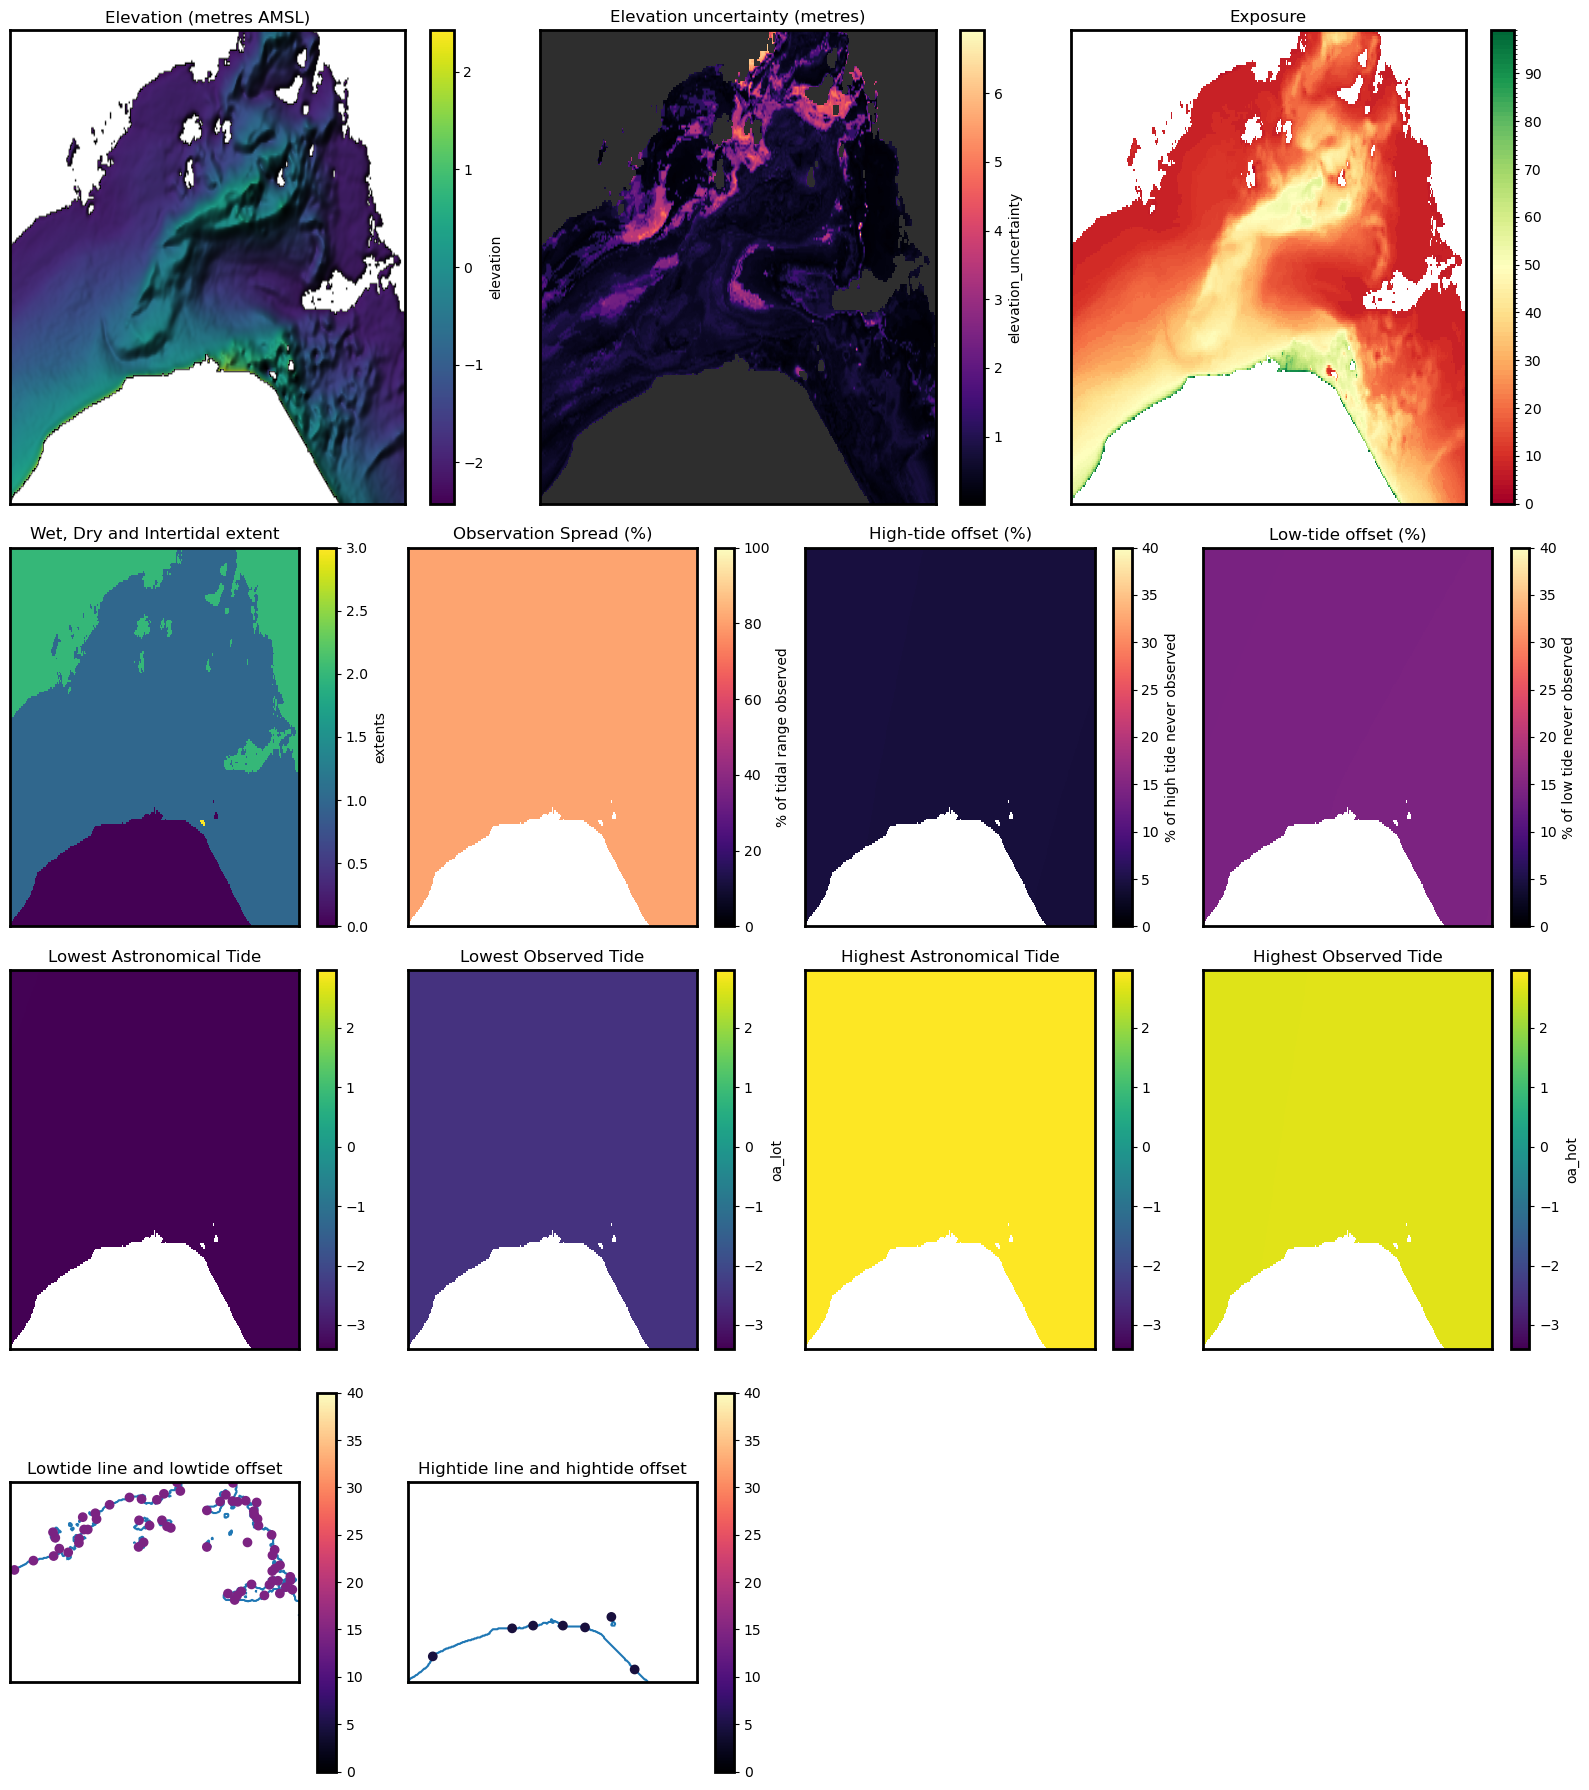

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["L"],
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["M"],
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [17]:
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug"
)

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson"
)
lowtideline.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson"
)
tidelines_gdf.to_crs("EPSG:4326").to_file(
    f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson"
)

### Close Dask client

In [ ]:
client.close()